<a href="https://colab.research.google.com/github/ArtemAvanesov/Roonyx-Labs/blob/master/5_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read and unzip data

In [0]:
base_dir = '/content/drive/My Drive/Colab/Roonyx/work_5'
zip_path = base_dir + '/leaf_diseases.zip'
unzip_path = base_dir + '/dataset'

!mkdir '$unzip_path'
!unzip -d '$unzip_path' '$zip_path'

# Plotting class distribution histogram

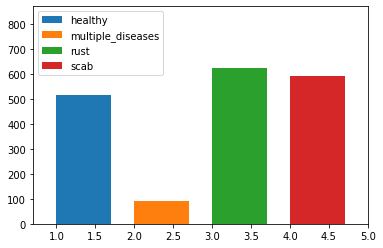

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

leafs = pd.read_csv(unzip_path+'/plant-pathology-2020-fgvc7/train.csv') 
y = np.array(leafs.drop(["image_id"], axis=1).values)

num_healthy = sum(y[:,0])
num_multiple_diseases = sum(y[:,1])
num_rust = sum(y[:,2])
num_scab = sum(y[:,3])

plt.hist([1]*num_healthy,bins=4, label = "healthy", width = 0.7)
plt.hist([2]*num_multiple_diseases,bins=4, label = "multiple_diseases", width = 0.7)
plt.hist([3]*num_rust,bins=4, label = "rust", width = 0.7)
plt.hist([4]*num_scab,bins=4, label = "scab", width = 0.7)
plt.ylim(0,max(num_healthy,num_multiple_diseases,num_rust, num_scab)*1.4)
plt.xlim(0.7,5)
plt.legend(loc='best')

# Splitting data

## Creating directories for train, test, validation

In [0]:
import os

splitted_dataset_path = base_dir + '/splitted_dataset'
os.mkdir(splitted_dataset_path)

train_dir = os.path.join(splitted_dataset_path, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(splitted_dataset_path, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(splitted_dataset_path, 'test')
os.mkdir(test_dir)

for path in [train_dir, test_dir, validation_dir]:
  for num_class in [0,1,2,3]:
    class_dir = os.path.join(path, str(num_class) + '_class')
    os.mkdir(class_dir)

## Search image indexes for each class

In [0]:
indices_class_0, indices_class_1, indices_class_2, indices_class_3 = [], [], [], []
for i in range(0, len(y),1):
  if(np.argmax(y[i]) == 0):
    indices_class_0.append(i)
  elif(np.argmax(y[i]) == 1):
    indices_class_1.append(i)
  elif(np.argmax(y[i]) == 2):
    indices_class_2.append(i)
  elif(np.argmax(y[i]) == 3):
    indices_class_3.append(i)

## Shuffling Index Arrays

In [0]:
import random

random.shuffle(indices_class_0)
random.shuffle(indices_class_1)
random.shuffle(indices_class_2)
random.shuffle(indices_class_3)

indices_classes = [indices_class_0, indices_class_1, indices_class_2, indices_class_3]

## Calculation num of elements in test, train and validation samples

In [7]:
import pandas as pd

percent_validation = 10
percent_test = 10

num_test = []
num_validation = []
num_train = []
for i in range(0,4,1):
  num_test.append(int(len(indices_classes[i])*percent_test/100))
  num_validation.append(int(len(indices_classes[i])*percent_validation/100))
  num_train.append(len(indices_classes[i])-num_test[-1] - num_validation[-1])

array_for_pandas = np.transpose([num_train, num_validation, num_test])

df = pd.DataFrame({
     '': ['Train', 'Validation', 'Test'],
     'Class 0': array_for_pandas[0,:],
     'Class 1': array_for_pandas[1,:],
     'Class 2': array_for_pandas[2,:],
     'Class 3': array_for_pandas[3,:]
 })

df

,,Class 0,Class 1,Class 2,Class 3
0,Train,414,73,498,474
1,Validation,51,9,62,59
2,Test,51,9,62,59


## Writing data with train, test and validation samples

In [0]:
import shutil

src = unzip_path + '/plant-pathology-2020-fgvc7/images'

# For test images
for num_class in [0,1,2,3]:
  test_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][0:num_test[num_class]]]
  for fname in test_fnames:
    shutil.copyfile(src+'/'+fname, test_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For validation images 
for num_class in [0,1,2,3]:
  validation_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class]:num_test[num_class] + num_validation[num_class]]]
  for fname in validation_fnames:
    shutil.copyfile(src+'/'+fname, validation_dir+'/'+str(num_class)+'_class'+'/'+fname)

# For train images
for num_class in [0,1,2,3]:
  train_fnames = ['Train_{}.jpg'.format(i) for i in indices_classes[num_class][num_test[num_class] + num_validation[num_class]:]]
  for fname in train_fnames:
    shutil.copyfile(src+'/'+fname, train_dir+'/'+str(num_class)+'_class'+'/'+fname)

# Подготовка данных

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=100,
        class_mode='categorical')

test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        batch_size=100,
        class_mode='categorical')

Found 1459 images belonging to 4 classes.
Found 181 images belonging to 4 classes.
Found 181 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


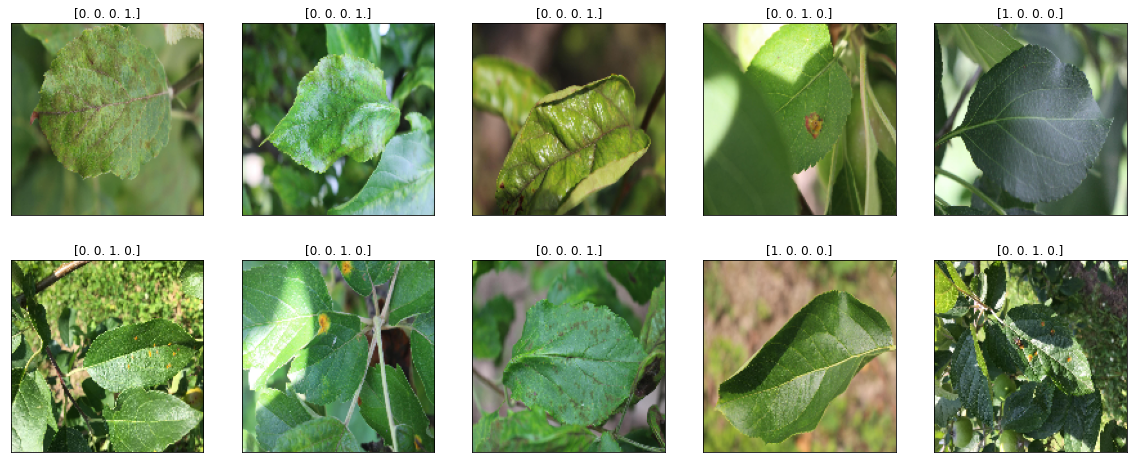

In [29]:
import matplotlib.pyplot as plt

imgs,labels = train_generator.next()

fix,axes = plt.subplots(2,5, figsize=(20,8), subplot_kw={'xticks':(),'yticks':()})
for target, image, ax in zip(labels[:10], imgs[:10], axes.ravel()):
    ax.imshow(image, cmap=plt.cm.binary)
    ax.set_title(target)

# Сверточная нейронная сеть


In [23]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten()) # Сворачиваем до одномерного
model.add(layers.Dense(64, activation='relu')) # Добавляем полносвязный слой
model.add(layers.Dense(4, activation='softmax')) # Добавляем softmax с 4 выходами (т.к. 4 класса)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 64)        36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 73984)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

# Обучение сети

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
              train_generator,
              steps_per_epoch=sum(num_train)//100,
              epochs=4,
              validation_data=validation_generator,
              validation_steps=sum(num_validation)//100)

Epoch 1/4
14/14 [==============================] - 58s 4s/step - loss: 1.5903 - accuracy: 0.3024 - val_loss: 1.2900 - val_accuracy: 0.3800
Epoch 2/4
14/14 [==============================] - 53s 4s/step - loss: 1.2611 - accuracy: 0.3201 - val_loss: 1.2723 - val_accuracy: 0.3580
Epoch 3/4
14/14 [==============================] - 60s 4s/step - loss: 1.2255 - accuracy: 0.3829 - val_loss: 1.2289 - val_accuracy: 0.3800
Epoch 4/4
14/14 [==============================] - 52s 4s/step - loss: 1.2392 - accuracy: 0.3915 - val_loss: 1.2115 - val_accuracy: 0.3086


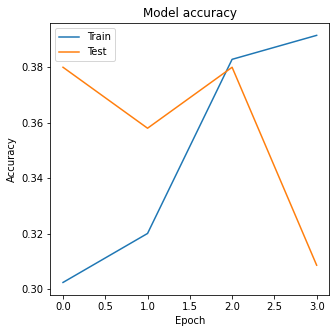

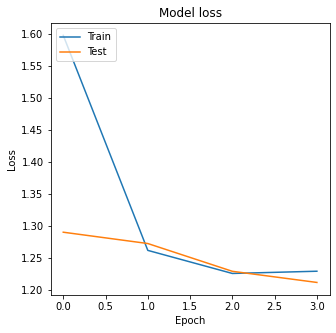

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')